In [1]:
# import sys
# !{sys.executable} -m pip install contextily

# Utilities
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Any, Optional, Tuple

import geopandas as gpd
import contextily as cx

import getpass

from sentinelhub import (
    SHConfig,
    DataCollection,
    SentinelHubCatalog,
    SentinelHubRequest,
    SentinelHubStatistical,
    SentinelHubStatisticalDownloadClient,
    BBox,
    bbox_to_dimensions,
    CRS,
    MimeType,
    Geometry,
    parse_time,
)

In [183]:
# Only run this cell if you have not created a configuration.

config = SHConfig()
# config.sh_client_id = getpass.getpass("Enter your SentinelHub client id")
# config.sh_client_secret = getpass.getpass("Enter your SentinelHub client secret")
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
# config.save("cdse")

In [8]:
config = SHConfig("cdse")

In [10]:
# define functions to extract statistics for all acquisition dates
def extract_stats(date, stat_data):
    d = {}
    for key, value in stat_data['outputs'].items():
        stats = value['bands']['B0']['stats']
        if stats['sampleCount']==stats['noDataCount']:
            continue
        else:
            d['date'] = [date]
            for stat_name, stat_value in stats.items():
                if (stat_name=='sampleCount' or stat_name=='noDataCount'):
                    continue
                else:
                    d[f'{key}_{stat_name}'] = [stat_value]
    return pd.DataFrame(d)

def read_acquisitions_stats(stat_data):
    df_li = []
    for aq in stat_data:
        date = aq['interval']['from'][:10]
        df_li.append(extract_stats(date, aq))
    return pd.concat(df_li)

def stats_to_df(stats_data):
    """Transform Statistical API response into a pandas.DataFrame"""
    df_data = []

    for single_data in stats_data["data"]:
        df_entry = {}
        is_valid_entry = True

        df_entry["interval_from"] = parse_time(single_data["interval"]["from"]).date()
        df_entry["interval_to"] = parse_time(single_data["interval"]["to"]).date()

        for output_name, output_data in single_data["outputs"].items():
            for band_name, band_values in output_data["bands"].items():
                band_stats = band_values["stats"]
                if band_stats["sampleCount"] == band_stats["noDataCount"]:
                    is_valid_entry = False
                    break

                for stat_name, value in band_stats.items():
                    col_name = f"{output_name}_{band_name}_{stat_name}"
                    if stat_name == "percentiles":
                        for perc, perc_val in value.items():
                            perc_col_name = f"{col_name}_{perc}"
                            df_entry[perc_col_name] = perc_val
                    else:
                        df_entry[col_name] = value

        if is_valid_entry:
            df_data.append(df_entry)

    return pd.DataFrame(df_data)
    
def plot_image(
    image: np.ndarray,
    factor: float = 1.0,
    clip_range: Optional[Tuple[float, float]] = None,
    **kwargs: Any
) -> None:
    """Utility function for plotting RGB images."""
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

In [11]:
# Loads and parses the file containing cities and their borders.
import json

FILENAME = "LAU_RG_01M_2023_4326.geojson"

with open(FILENAME) as file:
    data = json.load(file)

In [3155]:
# Searches for given city or LAU ID.
CITY = "Tallinn"
LAU_ID = N
INTERVAL = "2017-01-01", "2025-01-01"  # Interval of the data collection
MAX_CC = 0.25  # Maximum cloud coverage

if CITY is None and LAU_ID is None:
    raise ValueError("No city or LAU ID was given.")

selected = None

for feature in data["features"]:
    if (CITY and feature["properties"]["LAU_NAME"] == CITY)\
        or (LAU_ID and LAU_ID == feature["properties"]["LAU_ID"]):
        selected = feature
        break

if selected is None:
    if CITY is not None:
        raise ValueError(f"City \"{CITY}\" was not found.")
    else:
        raise ValueError(f"LAU ID \"{LAU_ID}\" was not found.")

if not CITY:
    CITY = selected["properties"]["LAU_NAME"]

print(selected["properties"])

# Calculate the bounding box of the city polygon
#print(selected["geometry"]["coordinates"][0])

if selected["geometry"]["type"] == "Polygon":
    coordinates = selected["geometry"]["coordinates"][0]
    top = bottom = coordinates[0][1]
    left = right = coordinates[0][0]
    for x, y in coordinates:
        left = min(left, x)
        right = max(right, x)
        top = max(top, y)
        bottom = min(bottom, y)

elif selected["geometry"]["type"] == "MultiPolygon":
    top = bottom = coordinates[0][1]
    left = right = coordinates[0][0]
    for poly in selected["geometry"]["coordinates"]:
        coordinates = poly[0]
        for x, y in coordinates:
            left = min(left, x)
            right = max(right, x)
            top = max(top, y)
            bottom = min(bottom, y)

else:
    raise ValueError(f"Unknown geometry type: {selected['geometry']['type']}")

selected["bbox"] = [left, bottom, right, top]

# Save the city metadata
try:
    os.mkdir(f"export/{CITY}")
except FileExistsError:
    pass
    
with open(f"export/{CITY}/meta_{CITY}.json", "w") as file:
    json.dump(selected, file)
      
geometry = Geometry(
    geometry=selected['geometry'],
    crs=CRS.WGS84)

size_ratio = abs(geometry.bbox.min_y-geometry.bbox.max_y)/abs(geometry.bbox.min_x-geometry.bbox.max_x)
res = 0.0006
resolution = (res, res*size_ratio)

{'GISCO_ID': 'EE_0784', 'CNTR_CODE': 'EE', 'LAU_ID': '0784', 'LAU_NAME': 'Tallinn', 'POP_2023': 453864.0, 'POP_DENS_2023': 2848.10389922, 'AREA_KM2': 2848.10389922, 'YEAR': 2023}


# NDVI

In [3131]:
evalscript_ndvi = """
//VERSION=3
function setup() {
  return {
    input: [{
      bands: [
        "B04",
        "B08",
        "dataMask"
      ]
    }],
    output: {
      bands: 4
    }
  }
}
  

function evaluatePixel(sample) {
    let val = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);
    let imgVals = null;
    
    if (val<-0.5) imgVals = [0.05,0.05,0.05,sample.dataMask];
    else if (val<-0.2) imgVals = [0.75,0.75,0.75,sample.dataMask];
    else if (val<-0.1) imgVals = [0.86,0.86,0.86,sample.dataMask];
    else if (val<0) imgVals = [0.92,0.92,0.92,sample.dataMask];
    else if (val<0.025) imgVals = [1,0.98,0.8,sample.dataMask];
    else if (val<0.05) imgVals = [0.93,0.91,0.71,sample.dataMask];
    else if (val<0.075) imgVals = [0.87,0.85,0.61,sample.dataMask];
    else if (val<0.1) imgVals = [0.8,0.78,0.51,sample.dataMask];
    else if (val<0.125) imgVals = [0.74,0.72,0.42,sample.dataMask];
    else if (val<0.15) imgVals = [0.69,0.76,0.38,sample.dataMask];
    else if (val<0.175) imgVals = [0.64,0.8,0.35,sample.dataMask];
    else if (val<0.2) imgVals = [0.57,0.75,0.32,sample.dataMask];
    else if (val<0.25) imgVals = [0.5,0.7,0.28,sample.dataMask];
    else if (val<0.3) imgVals = [0.44,0.64,0.25,sample.dataMask];
    else if (val<0.35) imgVals = [0.38,0.59,0.21,sample.dataMask];
    else if (val<0.4) imgVals = [0.31,0.54,0.18,sample.dataMask];
    else if (val<0.45) imgVals = [0.25,0.49,0.14,sample.dataMask];
    else if (val<0.5) imgVals = [0.19,0.43,0.11,sample.dataMask];
    else if (val<0.55) imgVals = [0.13,0.38,0.07,sample.dataMask];
    else if (val<0.6) imgVals = [0.06,0.33,0.04,sample.dataMask];
    else imgVals = [0,0.27,0,sample.dataMask];
    
    return imgVals
}
"""

In [3132]:
size_ratio = abs(geometry.bbox.min_y-geometry.bbox.max_y)/abs(geometry.bbox.min_x-geometry.bbox.max_x)

request_ndvi = SentinelHubRequest(
    evalscript=evalscript_ndvi,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A.define_from(
                name="s2l2a", service_url="https://sh.dataspace.copernicus.eu"
            ),
            time_interval=("2023-05-01", "2024-05-20"),
            other_args={"dataFilter": {"mosaickingOrder": "leastCC"}},
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    geometry=geometry,
    resolution=resolution,
    config=config,
)

ndvi_imgs = request_ndvi.get_data()

In [3133]:
print(
    f"Returned data is of type = {type(ndvi_imgs)} and length {len(ndvi_imgs)}."
)
print(
    f"Single element in the list is of type {type(ndvi_imgs[-1])} and has shape {ndvi_imgs[-1].shape}"
)

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (627, 627, 4)


Image type: uint8


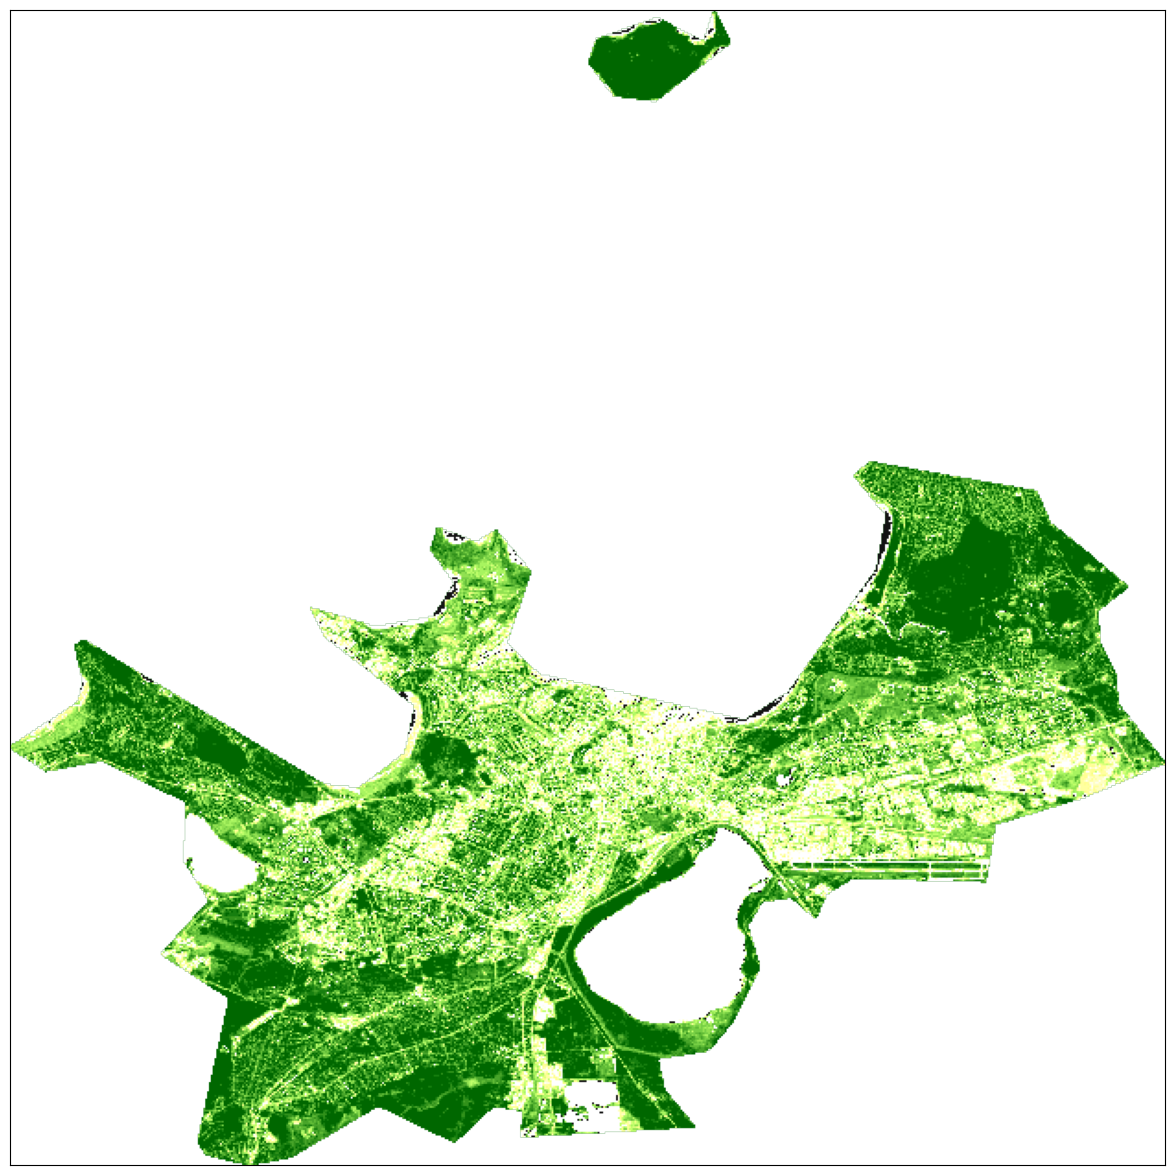

In [3134]:
image = ndvi_imgs[0]
print(f"Image type: {image.dtype}")
plot_image(image, factor=1.5 / 255, clip_range=(0, 1))

# Temperature

In [3135]:
evalscript_temperature = """
//VERSION=3
const blue_red = [
  [223, 0x002863],
  [253, 0x2e82ff],  
  [263, 0x80b3ff],
  [272, 0xe0edff],
  [273, 0xffffff],
  [274, 0xfefce7],
  [283, 0xFDE191],
  [293, 0xf69855],
  [303, 0xec6927],
  [323, 0xaa2d1d],
];

const viz = new ColorRampVisualizer(blue_red);

function setup() {
  return {
    input: [{
      bands: ["S7", "dataMask"]
    }],
    output: [{
        id: "default",
        bands: 4
      },
      {
        id: "eobrowserStats",
        bands: 1
      },
      {
        id: "index",
        bands: 1,
        sampleType: "FLOAT32"
      },
      {
        id: "dataMask",
        bands: 1
      },
    ],
  }
}

function evaluatePixel(samples) {
  let val = viz.process(samples.S7);
  val.push(samples.dataMask);

  return {
    default: val,
    eobrowserStats: [samples.S7],
    index: [samples.S7],
    dataMask: [samples.dataMask],
  };
}
"""

In [3136]:
request_temperature = SentinelHubRequest(
    evalscript=evalscript_temperature,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL3_SLSTR.define_from(
                name="s3slstr", service_url="https://sh.dataspace.copernicus.eu"
            ),
            time_interval=("2018-05-01", "2018-05-09"),
            other_args={"dataFilter": {"mosaickingOrder": "leastCC"}},
            #maxcc=MAX_CC,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    geometry=geometry,
    config=config,
)

temperature_imgs = request_temperature.get_data()

In [3137]:
print(
    f"Returned data is of type = {type(temperature_imgs)} and length {len(temperature_imgs)}."
)
print(
    f"Single element in the list is of type {type(temperature_imgs[-1])} and has shape {temperature_imgs[-1].shape}"
)

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (256, 256, 4)


Image type: uint8


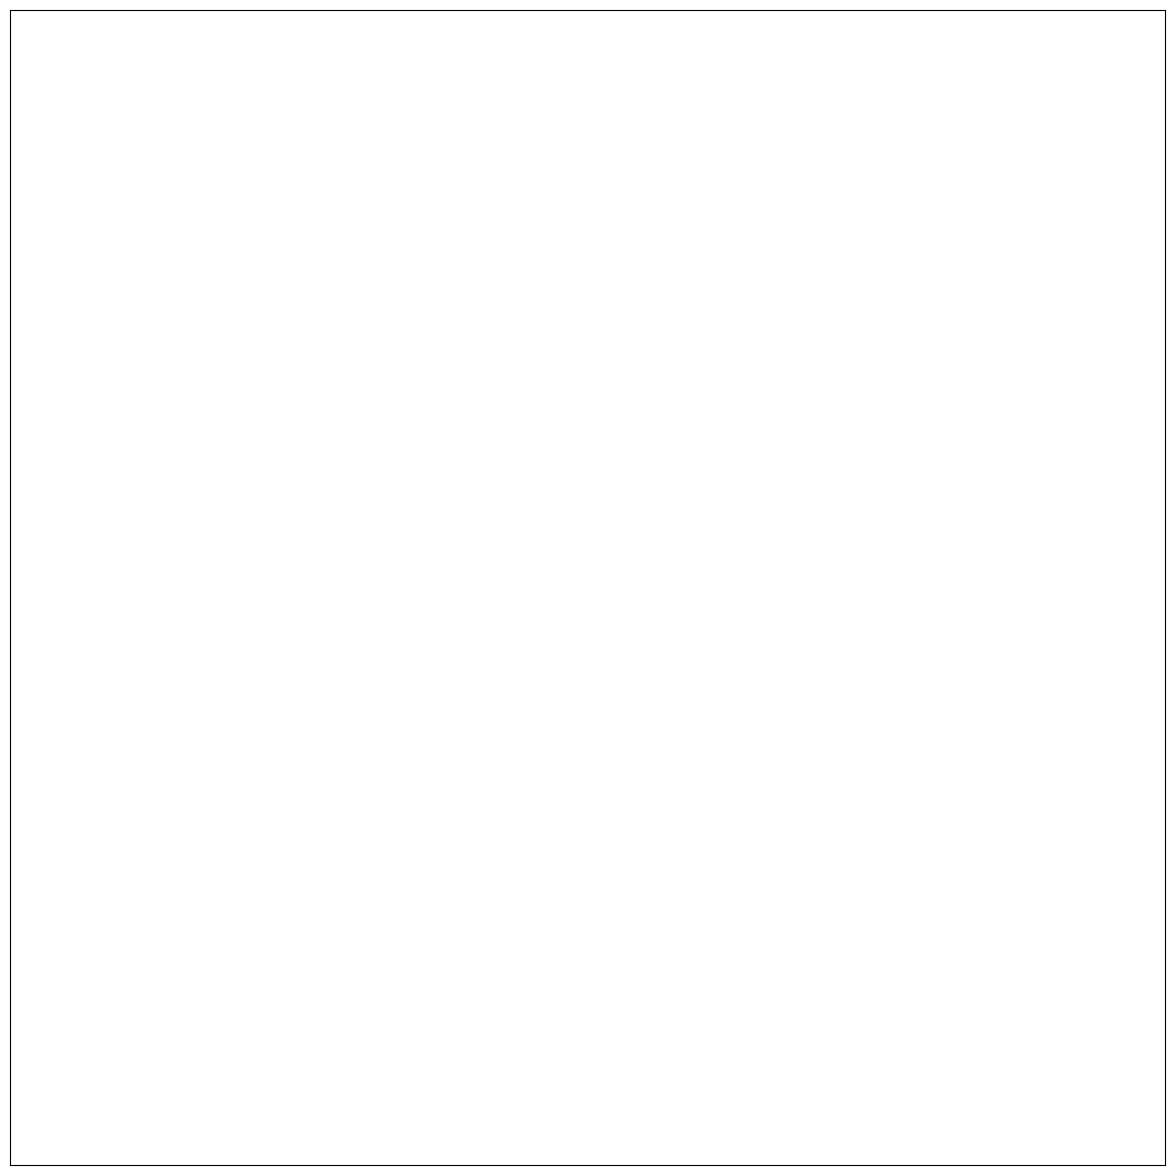

In [3138]:
image = temperature_imgs[0]
print(f"Image type: {image.dtype}")

plot_image(image, factor = 1 / 255, clip_range=(0, 1))

# Aggregate NDVI

In [3139]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: [{
      bands: [
        "B04",
        "B08",
        "dataMask"
      ]
    }],
    output: [
      {
        id: "data",
        bands: 1
      },
      {
        id: "dataMask",
        bands: 1
      }]
  };
}

function evaluatePixel(samples) {
    let index = (samples.B08 - samples.B04) / (samples.B08+samples.B04);
    return {
        data: [index],
        dataMask: [samples.dataMask],
    };
}

"""


aggregation = SentinelHubStatistical.aggregation(
    evalscript=evalscript, time_interval=INTERVAL, aggregation_interval="P1M", resolution=(0.0006, 0.0006),
)

input_data = SentinelHubStatistical.input_data(
    DataCollection.SENTINEL2_L2A.define_from("s2l2a", service_url=config.sh_base_url), maxcc=MAX_CC
)

request = SentinelHubStatistical(
    aggregation=aggregation,
    input_data=[input_data],
    geometry=geometry,
    config=config,
)

response = request.get_data()
ndvi_df = stats_to_df(response[0])

In [3140]:
ndvi_df

,interval_from,interval_to,data_B0_min,data_B0_max,data_B0_mean,data_B0_stDev,data_B0_sampleCount,data_B0_noDataCount
0,2017-02-01,2017-03-01,-1.0,1.000000,0.171749,0.344626,250173,178557
1,2017-03-01,2017-04-01,-1.0,1.000000,0.254516,0.338105,250173,178557
2,2017-04-01,2017-05-01,-1.0,0.846416,0.293059,0.286125,250173,220483
3,2017-05-01,2017-06-01,-1.0,0.907529,0.388478,0.335333,250173,178557
4,2017-06-01,2017-07-01,-1.0,0.970455,0.482796,0.408753,250173,178557
...,...,...,...,...,...,...,...,...
80,2024-08-01,2024-09-01,-1.0,0.956872,0.475395,0.401405,250173,178557
81,2024-09-01,2024-10-01,-1.0,0.961280,0.459730,0.425005,250173,178557
82,2024-10-01,2024-11-01,-1.0,1.000000,0.342063,0.423879,250173,178557
83,2024-11-01,2024-12-01,-1.0,0.860253,0.123600,0.290563,250173,178557


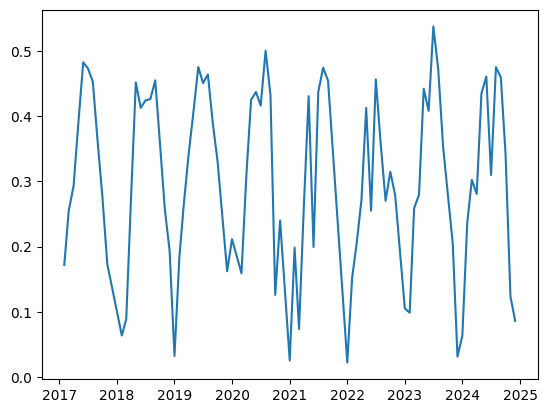

In [3141]:
plt.plot(ndvi_df["interval_from"], ndvi_df["data_B0_mean"])

# Aggregate temperature

In [3142]:
evalscript = """
//VERSION=3

function evaluatePixel(samples) {
    return {
      //data: [(samples.S7+samples.S8+samples.S9)/3 - 273.15],
      data: [samples.S9 - 273.15],
      dataMask: [samples.dataMask]
    };
}

function setup() {
  return {
    input: [{
      bands: [
        "S7",
        "S8",
        "S9",
        "dataMask"
      ]
    }],
    output: [
      {
        id: "data",
        bands: 1
      },
      {
        id: "dataMask",
        bands: 1
      }]
  }
}

"""

request = SentinelHubStatistical(
    aggregation=SentinelHubStatistical.aggregation(
        evalscript=evalscript,
        time_interval=INTERVAL,
        aggregation_interval='P1M',
        resolution=resolution,        
    ),
    input_data=[
        SentinelHubStatistical.input_data(
            DataCollection.SENTINEL3_SLSTR.define_from("s3slstr", service_url=config.sh_base_url), 
            maxcc=MAX_CC
      ),
    ],
    geometry=geometry,
    config=config
)

response = request.get_data()
temperature_df = stats_to_df(response[0])

In [3143]:
temperature_df

,interval_from,interval_to,data_B0_min,data_B0_max,data_B0_mean,data_B0_stDev,data_B0_sampleCount,data_B0_noDataCount
0,2017-01-01,2017-02-01,-10.139990,-0.549994,-8.240175,2.322442,393129,297388
1,2017-02-01,2017-03-01,-7.780005,-7.780005,-7.780005,0.000000,393129,371698
2,2017-03-01,2017-04-01,-8.009985,-8.009985,-8.009985,0.000000,393129,368909
3,2017-05-01,2017-06-01,6.149988,13.010004,10.874252,1.077806,393129,281053
4,2017-06-01,2017-07-01,34.059990,44.170006,37.403437,1.470530,393129,343197
...,...,...,...,...,...,...,...,...
73,2024-07-01,2024-08-01,-3.350012,17.200006,10.903155,3.018102,393129,281053
74,2024-08-01,2024-09-01,-49.950005,16.260004,7.659531,15.398106,393129,281053
75,2024-10-01,2024-11-01,-45.170006,-38.489998,-41.275488,1.173852,393129,281053
76,2024-11-01,2024-12-01,-3.929999,-3.199988,-3.675227,0.135917,393129,319808


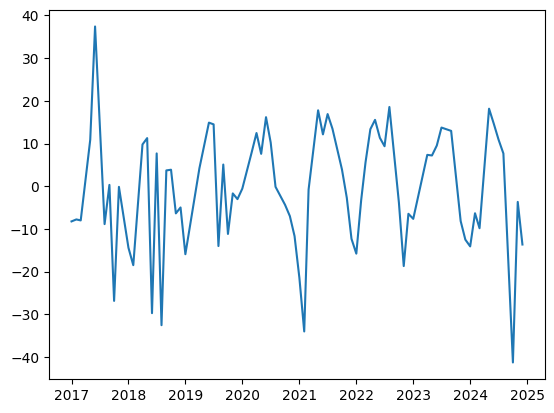

In [3144]:
plt.plot(temperature_df["interval_from"], temperature_df["data_B0_mean"])

# Aggregate both

In [3145]:
# Join and clean up NDVI and temperature data frames

joined = ndvi_df.join(temperature_df.set_index("interval_from"), on="interval_from", lsuffix="_ndvi", how="inner")
joined["interval_from"] = pd.to_datetime(joined.interval_from)
joined["year"] = joined["interval_from"].apply(lambda x: x.year)
joined["month"] = joined["interval_from"].apply(lambda x: x.month)

joined = joined.rename(
    columns={
        "data_B0_min_ndvi": "ndvi_min",
        "data_B0_mean_ndvi": "ndvi_mean",
        "data_B0_max_ndvi": "ndvi_max",
        "data_B0_min": "temp_min",
        "data_B0_mean": "temp_mean",
        "data_B0_max": "temp_max",

    })[[
    "year",
    "month",
    "ndvi_min",
    "ndvi_mean",
    "ndvi_max",
    "temp_min",
    "temp_mean",
    "temp_max",
    ]]

In [3146]:
# Select only each year's hottest months
hottest_month = joined.loc[joined.groupby("year").idxmax()["temp_mean"]]
hottest_month

,year,month,ndvi_min,ndvi_mean,ndvi_max,temp_min,temp_mean,temp_max
4,2017,6,-1.0,0.482796,0.970455,34.059990,37.403437,44.170006
13,2018,5,-1.0,0.451924,0.949864,7.149988,11.261880,15.140009
26,2019,6,-1.0,0.475519,0.965764,-2.209998,14.886816,24.189997
36,2020,6,-1.0,0.437247,0.933036,12.540003,16.160969,18.350000
46,2021,5,-1.0,0.430915,0.949623,6.429986,17.769276,25.339991
58,2022,8,-1.0,0.358142,0.977143,14.439997,18.549322,22.350000
68,2023,7,-1.0,0.537830,0.941331,-7.359992,13.732215,23.809992
77,2024,5,-1.0,0.435037,0.929536,8.499994,18.151834,25.850000


In [3147]:
# Write the hottest months data frame to the meta file.

with open(f"export/{CITY}/meta_{CITY}.json") as file:
    metadata = json.load(file)
    
stats = {
    "year": list(hottest_month["year"]),
    "ndvi_mean": list(hottest_month["ndvi_mean"]),
    "temp_mean": list(hottest_month["temp_mean"]),
}
metadata["stats"] = stats

with open(f"export/{CITY}/meta_{CITY}.json", "w") as file:
    json.dump(metadata, file)

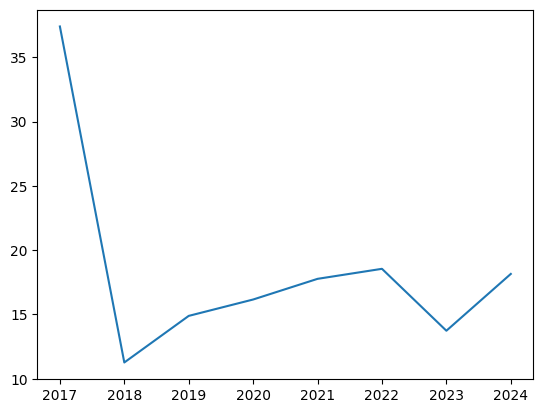

In [3148]:
plt.plot(hottest_month.year, hottest_month.temp_mean)

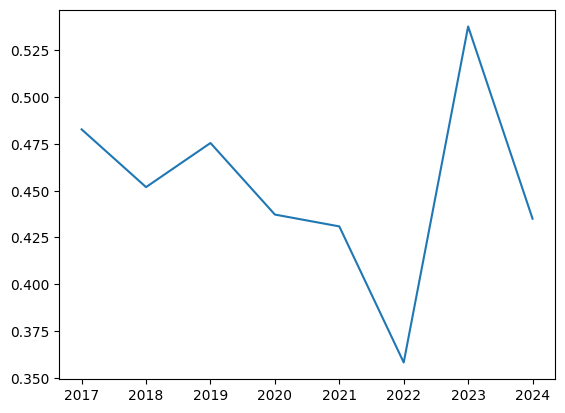

In [3149]:
plt.plot(hottest_month.year, hottest_month.ndvi_mean)

# Get yearly data

In [3150]:
months = []
for x in hottest_month.iterrows():
    year = int(x[1].year)
    month = int(x[1].month)
    next_month = month+1
    if next_month == 13:  # Handle month overflow
        next_month = 1
        next_year = year + 1
    else:
        next_year = year

    months.append((f"{year}-{month:02}-01", f"{next_year}-{next_month:02}-01"))
months

[('2017-06-01', '2017-07-01'),
 ('2018-05-01', '2018-06-01'),
 ('2019-06-01', '2019-07-01'),
 ('2020-06-01', '2020-07-01'),
 ('2021-05-01', '2021-06-01'),
 ('2022-08-01', '2022-09-01'),
 ('2023-07-01', '2023-08-01'),
 ('2024-05-01', '2024-06-01')]

## NDVI

In [3151]:
%%time

evalscript = """
//VERSION=3

function setup() {
  return {
    input: [
      {
        bands: [
          "B04",
          "B08",
          "dataMask"
        ]
      }
    ],
    output: 
      {
        bands: 1,
        sampleType: "FLOAT32",
      },
    
  }
}

function evaluatePixel(samples) {
    return [samples.dataMask == 0 ? NaN : index(samples.B08, samples.B04)];
}
"""

ndvi_results = {}

for i, month in enumerate(months):
    print(f"Downloading interval ({i+1}/{len(months)}):", month)
    request = SentinelHubRequest(
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A.define_from(
                    name="s2l2a", service_url="https://sh.dataspace.copernicus.eu"
                ),
                time_interval=month,
                other_args={"dataFilter": {"mosaickingOrder": "leastCC"}},
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        geometry=geometry,
        bbox=geometry.bbox,
        resolution=resolution,
        config=config,
    )
    ndvi_results[month[0]] = request.get_data()

CPU times: user 166 ms, sys: 29.6 ms, total: 196 ms
Wall time: 5.13 s


In [3152]:
import rasterio

for name, image in ndvi_results.items():
    im = image[0]
    with rasterio.open(
        f"export/{CITY}/ndvi_{CITY}_{name[:4]}.tiff",
        'w',
        driver='GTiff',
        height=im.shape[0],
        width=im.shape[1],
        count=1,
        dtype=im.dtype,
        crs=rasterio.crs.CRS.from_epsg(4326),
        transform=rasterio.transform.from_bounds(*geometry.bbox, im.shape[1], im.shape[0]),
    ) as dst:
        dst.write(im, 1)

## Temperature

In [3153]:
%%time

evalscript = """
//VERSION=3

function setup() {
  return {
    input: [
      {
        bands: [
          "S9",
          "dataMask",
        ]
      }
    ],
    output: 
      {
        bands: 1,
        sampleType: "FLOAT32",
      },
    
  }
}

let minVal = 223.15;

function evaluatePixel(samples) {
    let val = samples.S9;
    let converted = (val - minVal) * 0.01;
    return [converted];
    //return [samples.dataMask == 0 ? 0 : (val - minVal) * 0.01];
}
"""

temp_results = {}

for i, month in enumerate(months):
    print(f"Downloading interval ({i+1}/{len(months)}):", month)
    request = SentinelHubRequest(
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL3_SLSTR.define_from(
                    name="s3slstr", service_url="https://sh.dataspace.copernicus.eu"
                ),
                time_interval=month,
                other_args={"dataFilter": {"mosaickingOrder": "leastCC"}},
                maxcc=MAX_CC,
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        geometry=geometry,
        config=config,
    )
    temp_results[month[0]] = request.get_data()

CPU times: user 91.5 ms, sys: 11.7 ms, total: 103 ms
Wall time: 2.14 s


In [3154]:
for name, image in temp_results.items():
    im = image[0]

    # Replace below average values with NaN
    mean = np.nanmean(im)
    im = np.array([np.array([np.nan if np.isnan(y) else (np.nan if y < mean else y) for y in x]) for x in im])

    with rasterio.open(
        f"export/{CITY}/temp_{CITY}_{name[:4]}.tiff",
        'w',
        driver='GTiff',
        height=im.shape[0],
        width=im.shape[1],
        count=1,
        dtype=im.dtype,
        crs=rasterio.crs.CRS.from_epsg(4326),
        transform=rasterio.transform.from_bounds(*geometry.bbox, im.shape[1], im.shape[0]),
    ) as dst:
        dst.write(im, 1)

/tmp/ipykernel_2334/1640858353.py:5: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(im)
